#Time history analysis in single degree of freedom (SDOF)

Inser description later.

 In the following figure, a fragility model developed using this method is presented: 
<img src="../../../../../figures/fragility_example.png" height="200" width="400" align="middle">

##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of the folder containing this input using the parameter input_folder.

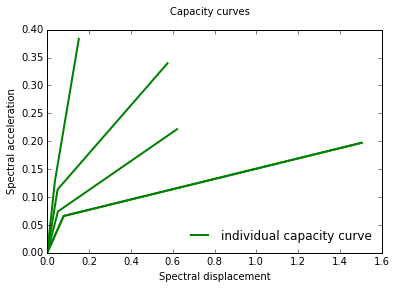

{'Say': [0.12821, 0.074098, 0.11358, 0.065933], 'periods': [1.52, 1.63], 'Sa': [[0.0, 0.12821, 0.29829, 0.31955, 0.3833], [0.0, 0.074098, 0.17239, 0.18468, 0.22154], [0.0, 0.11358, 0.26426, 0.28309, 0.3396], [0.0, 0.065933, 0.1534, 0.16433, 0.19713]], 'Sd': [[0.0, 0.036802, 0.11298, 0.1225, 0.15107], [0.0, 0.051318, 0.43086, 0.4783, 0.62062], [0.0, 0.049906, 0.39992, 0.44367, 0.57493], [0.0, 0.078588, 1.028, 1.1467, 1.5027]], 'type': 'Sd-Sa', 'Sdy': [0.036802, 0.051318, 0.049906, 0.078588], 'gamma': [1.24, 1.24], 'heights': [6.0, 6.0]}


In [4]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../rmtk_data/capacity_curves_sdof.csv'
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)

## Load ground motion records

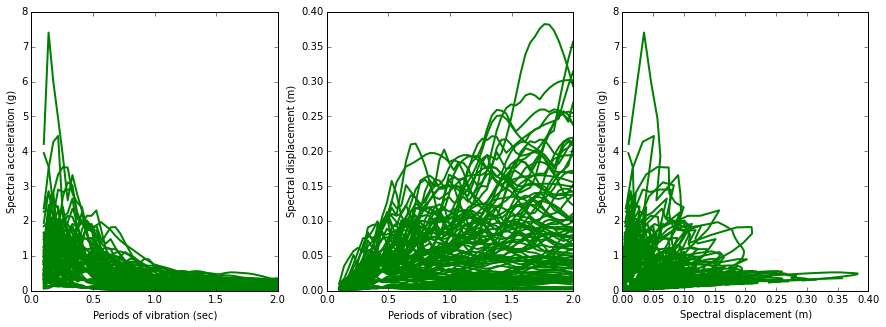

In [9]:
gmrs_folder = '../../../../../rmtk_data/accelerograms'
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.1
maxT = 2
utils.plot_response_spectra(gmrs,minT,maxT)

##Calculate fragility function


25%
[0.036802, 0.06536900000000001, 0.093936, 0.15107]
50%
[0.051318, 0.1936435, 0.33596899999999996, 0.62062]
75%
[0.049906, 0.18116200000000002, 0.31241800000000003, 0.57493]
100%
[0.078588, 0.434616, 0.790644, 1.5027]


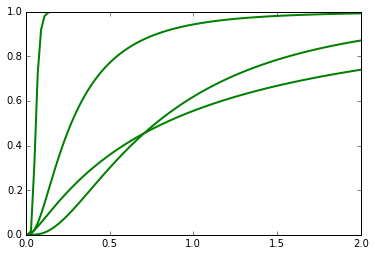

In [10]:
import NLTHA_on_SDOF

damage_model = utils.read_damage_model('../../../../../rmtk_data/damage_model.csv')
damping = 0.05
T = 2.0
degradation = True
PDM, Sds = NLTHA_on_SDOF.calculate_fragility(capacity_curves,gmrs,damage_model,damping,degradation)
fragility_model = utils.calculate_mean_fragility(gmrs,PDM,T,damping,'Sa',damage_model)
utils.plot_fragility_model(fragility_model,0.01,2)